# Optimised Python
In this notebook we will look at a few useful built in methods for getting the most out of our Python code

In [1]:
import math
import numpy as np
from datetime import datetime

In [2]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi)

To demonstrate Python's performance we will use a short function

As the name suggest **cart2pol** converts a pair of cartesian coordinates [x, y] to polar coordinates [r, phi]

In [3]:
from IPython.core.display import Image 
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Polar_to_cartesian.svg/1024px-Polar_to_cartesian.svg.png',width=400)

In [4]:
x = 3
y = 4
r, phi = cart2pol(x,y)

print('r   = ',r,'\nphi = ' ,phi)

r   =  5.0 
phi =  0.9272952180016122


All well and good. However, what if we want to convert a list of cartesian coordinates to polar coordinates?

We could **loop** through both lists and perform the conversion for each x-y pair:

In [17]:
def cart2pol_list(list_x, list_y):
    # Prepare empty lists for r and phi values
    r = np.empty(len(list_x))
    phi = np.empty(len(list_x))
    
    # Loop through the lists of x and y, calculating the r and phi values
    for i in range(len(list_x)):
        r[i] = np.sqrt(list_x[i]**2 + list_y[i]**2)
        phi[i] = np.arctan2(list_y[i], list_x[i])
    
    return(r, phi)

In [18]:
x_list = np.sin(np.arange(0,2*np.pi,0.1))
y_list = np.cos(np.arange(0,2*np.pi,0.1))

These coordinates make a circle centered at [0,0]

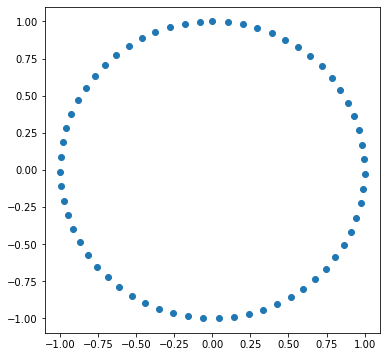

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(x_list,y_list)

In [20]:
r_list, phi_list = cart2pol_list(x_list,y_list)
print(r_list)
print(phi_list)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 1.57079633  1.47079633  1.37079633  1.27079633  1.17079633  1.07079633
  0.97079633  0.87079633  0.77079633  0.67079633  0.57079633  0.47079633
  0.37079633  0.27079633  0.17079633  0.07079633 -0.02920367 -0.12920367
 -0.22920367 -0.32920367 -0.42920367 -0.52920367 -0.62920367 -0.72920367
 -0.82920367 -0.92920367 -1.02920367 -1.12920367 -1.22920367 -1.32920367
 -1.42920367 -1.52920367 -1.62920367 -1.72920367 -1.82920367 -1.92920367
 -2.02920367 -2.12920367 -2.22920367 -2.32920367 -2.42920367 -2.52920367
 -2.62920367 -2.72920367 -2.82920367 -2.92920367 -3.02920367 -3.12920367
  3.05398163  2.95398163  2.85398163  2.75398163  2.65398163  2.55398163
  2.45398163  2.35398163  2.25398163  2.15398163  2.05398163  1.95398163
  1.85398163  1.75398163  1.65398163]


This is a bit time consuming to type out though, surely there is a better way to make our functions work for lists of inputs?

Step forward **vectorise**

In [21]:
cart2pol_vec = np.vectorize(cart2pol)

In [22]:
r_list_vec, phi_list_vec = cart2pol_vec(x_list, y_list)

Like magic! We can assure ourselves that these two methods produce the same answers

In [ ]:
print(r_list == r_list_vec)
print(phi_list == phi_list_vec)

Lastly, we could also have relied from the beginning on the fact that the numpy functions we used in our original cart2pol already accept lists and numpy arrays as input:

In [24]:
x_nparray = np.array(x_list)
y_nparray = np.array(y_list)
r,phi = cart2pol(x_nparray, y_nparray)

But how do they perform?

We can use Python's magic **%timeit** function to test this

In [29]:
%timeit cart2pol_list(x_list, y_list)

251 µs ± 7.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
%timeit cart2pol_vec(x_list, y_list)

125 µs ± 663 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
%timeit cart2pol(x_list, y_list)

3.87 µs ± 94 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [32]:
%timeit cart2pol(x_nparray, y_nparray)

3.72 µs ± 73.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


From our experiments with `%timeit`, we learn the following:
- It was significantly faster, both for code writing and at runtime, to use **vectorise** rather than manually looping through lists
- Using **numpy functions** directly on arrays was 1-2 orders of magnitude faster than either of the previous two
- It is more efficient to use **numpy arrays** than lists

-----------

### Multiprocessing
Another important consideration when code becomes computationally intensive is **multiprocessing**. Python normally runs on one core, so you won't feel the full benefit of your quad-core or greater machine. You can see this when you run a section of code. To demonstrate the effect of multiprocessing we'll need some heftier maths:

In [14]:
def do_maths(start=0, num=10):
    pos = start
    big = 1000 * 1000
    ave = 0
    while pos < num:
        pos += 1
        val = math.sqrt((pos - big) * (pos - big))
        ave += val / num

    return int(ave)

In [15]:
t0 = datetime.now()

do_maths(num=30000000)

dt = datetime.now() - t0
print("Done in {:,.2f} sec.".format(dt.total_seconds()))

Done in 15.20 sec.


In [16]:
import multiprocessing

In [17]:
t0 = datetime.now()

pool = multiprocessing.Pool()
processor_count = multiprocessing.cpu_count()
# processor_count = 2 # we can Python to use a specific number of cores if desired

print(f"Computing with {processor_count} processor(s)")
tasks = []
for n in range(1, processor_count + 1):
    task = pool.apply_async(do_maths, (30000000 * (n - 1) / processor_count,
                                      30000000 * n / processor_count))
    
    tasks.append(task)

pool.close()
pool.join()

dt = datetime.now() - t0
print("Done in {:,.2f} sec.".format(dt.total_seconds()))


Computing with 16 processor(s)
Done in 1.49 sec.


Note that you can recover results stored in the task list with get(). This list will be in the same order as that which you used to spawn the processes

In [18]:
for t in tasks:
    print(t.get())

470833
906250
1229166
1390625
1487500
1552083
1598214
1632812
1659722
1681250
1698863
1713541
1725961
1736607
1745833
1753906


The structure of a multiproccess call is:

```python
pool = multiprocessing.Pool() # Make a pool ready to recieve tasks
results = [] # empty list for results
for n in range(1, processor_count + 1): # Loop for assigning a number of tasks
    result = pool.appy_async(function, (arguments)) # make a task by passing it a function and arguments
    results.append(result) # when result(s) of this task are ready, append them to the list

pool.close() # tell async there are no more tasks coming
pool.join() # start running the tasks concurrently

for t in results:
    t.get() # retrieve your results, You could print or assign each result to a variable for later analysis
```

### Why can't we multithread in Python?

If you have experience of other programming languages, you may wonder why we can't assign tasks to multiple threads to speed up execution. We are prevented from doing this by the Global Interpreter Lock (GIL). This is a lock on the interpreter which ensures that only one thread can be in a state of execution at any one time. This is essential to protect Python's reference system that keeps track of all of the objects in memory. 

To get around this lock we spawn several processes which each have their own instance of the interpreter and allocated memory so cannot block one another or cause mischief with references. There's a great summary of the GIL on the real Python website [here](https://realpython.com/python-gil/)

**tl;dr** multithreading won't speed up your compute heavy calcualtions as only one thread can execute at any time. Use multiprocessing instead

---------------------
Multiprocessing example adapted from [Talk Python To Me Training: async techniques](https://training.talkpython.fm/courses/details/async-in-python-with-threading-and-multiprocessing)
